# MULTI-INSTANCE LEARNING

In [1]:
# !yes | sudo dpkg -i /kaggle/input/libvips-pyvips-installation-and-getting-started/libvips/*.deb
# !pip install /kaggle/input/libvips-pyvips-installation-and-getting-started/pyvips/pyvips-2.2.1-py2.py3-none-any.whl --no-index --find-links /kaggle/input/libvips-pyvips-installation-and-getting-started/pyvips
!pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

  Cloning https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to /tmp/pip-req-build-kyx7fh_p
  Running command git clone --filter=blob:none --quiet https://github.com/ildoonet/pytorch-gradual-warmup-lr.git /tmp/pip-req-build-kyx7fh_p
  Resolved https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to commit 6b5e8953a80aef5b324104dc0c2e9b8c34d622bd
  Preparing metadata (setup.py) ... done
  Created wheel for warmup-scheduler: filename=warmup_scheduler-0.3.2-py3-none-any.whl size=3863 sha256=37d40b6cae4ee65c5e39d114701bd884ff6f93beda0f996e20d98b06bbb8a256
  Stored in directory: /tmp/pip-ephem-wheel-cache-7kj8z5j4/wheels/49/78/e6/9168d5844935482a171c7880a0626fa1c6c412b55666635f59
Successfully built warmup-scheduler


In [2]:
import os, gc, time, copy
import h5py
import pickle
import json
import subprocess
os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = pow(2,40).__str__()
from pathlib import Path
from tqdm.auto import tqdm
tqdm.pandas()
from collections import defaultdict

import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing

import tensorflow as tf

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler, WeightedRandomSampler
import torchvision
from torchvision import transforms
from warmup_scheduler import GradualWarmupScheduler

# from torchvision.transforms import v2

import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

import IPython.display as display

from PIL import Image
import cv2
# import pyvips
import albumentations as A
from albumentations.pytorch import ToTensorV2

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
config = dict(
    seed = 42,
    folds = 5,
    img_size = [224, 224],
    learning_rate = 3e-4, # 2e-5, 3e-4
    eta_min = 1e-5,
    epochs = 50,
    batch_size = 8,
    num_workers = 2,
    num_tiles = 20,
    warmup_epoch = 1,
    warmup_factor = 10,
)

def seeding(SEED):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    torch.manual_seed(SEED)
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(SEED)
        torch.cuda.manual_seed_all(SEED)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
#     os.environ['TF_CUDNN_DETERMINISTIC'] = str(SEED)
#     tf.random.set_seed(SEED)
#     keras.utils.set_random_seed(seed=SEED)
    print('seeding done!!!')

def flush():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
    
seeding(config['seed'])

seeding done!!!


In [4]:
DATA_PATH = Path("../input/UBC-OCEAN/")
os.listdir(DATA_PATH)

['updated_image_ids.json',
 'test_thumbnails',
 'sample_submission.csv',
 'train_images',
 'train_thumbnails',
 'train.csv',
 'test.csv',
 'test_images']

In [5]:
train_df = pd.read_csv(DATA_PATH/'train.csv')
test_df = pd.read_csv(DATA_PATH/'test.csv')
sample_df = pd.read_csv(DATA_PATH/'sample_submission.csv')

get_train_images = lambda x: "/kaggle/input/UBC-OCEAN/train_images/" + str(x) + ".png"
get_test_images = lambda x: "/kaggle/input/UBC-OCEAN/test_images/" + str(x) + ".png"

check_path = lambda path: tf.io.gfile.exists(path)

train_df['image_path'] = train_df.loc[:, 'image_id'].progress_apply(get_train_images)
train_df['exists'] = train_df.loc[:, 'image_path'].map(check_path)

print("Checking training data ...")
display.display(train_df['exists'].value_counts())
train_df = train_df[train_df['exists'] == True]
train_df.reset_index(drop=True, inplace=True)

test_df['image_path'] = test_df.loc[:, 'image_id'].progress_apply(get_test_images)
test_df['exists'] = test_df.loc[:, 'image_path'].map(check_path)

print("Checking test data ...")
display.display(test_df['exists'].value_counts())
test_df = test_df[test_df['exists'] == True]
test_df.reset_index(drop=True, inplace=True)

  0%|          | 0/538 [00:00<?, ?it/s]

Checking training data ...


exists
True    538
Name: count, dtype: int64

  0%|          | 0/1 [00:00<?, ?it/s]

Checking test data ...


exists
True    1
Name: count, dtype: int64

In [6]:
labels = train_df['label'].unique().tolist()
id2label = {l:i for i, l in enumerate(labels)}
label2id = {i:l for i, l in enumerate(labels)}

train_df['target'] = train_df['label'].map(id2label)
# train_df['target'].value_counts()

In [7]:
def get_distributions(data) -> dict:
    distributions = data['label'].value_counts().reset_index()
    return {k: 1.0 / v for k, v in zip(distributions['label'], distributions['count'])}

distributions = get_distributions(train_df)

train_df['weight'] = train_df['label'].map(distributions)
class_weights = torch.tensor(list(distributions.values()), dtype=torch.float)

In [8]:
def read_images(image_path, scale_factor=2, longest_edge=15_000):
    image = pyvips.Image.new_from_file(image_path, access='sequential')
    image = image.resize(1.0/scale_factor).numpy()
    
#     image_thumbnail = image_thumbnail = pyvips.Image.thumbnail(image_path, longest_edge)
#     image = np.ndarray(
#         buffer=image_thumbnail.write_to_memory(),
#         dtype=np.uint8,
#         shape=[image_thumbnail.height, image_thumbnail.width, image_thumbnail.bands]
#     )

    return image

In [9]:
# def create_patches(data, patch_size=256, scale_factor=2):
#     flush()

#     k=0
#     IMAGES = list()
#     LABELS = list()
#     IMAGE_IDS = list()

#     # define the lower and upper ranges for the black and white colors in HSV
#     lower_black = np.array([0, 0, 0])
#     upper_black = np.array([30, 30, 30])     # [179, 50, 50]
#     lower_white = np.array([179, 30, 30])   # [0, 0, 200]
#     upper_white = np.array([179, 240, 50])   # [179, 50, 255]

#     for i in tqdm(range(data.shape[0])):
# #         img = cv.imread(data.loc[i, 'image_path'])
#         img = read_images(data.loc[i, 'image_path'], scale_factor=scale_factor)
#         img = cv.resize(img, (4096, 2048))
#         h, w = img.shape[:2]
#         rows = np.split(img, h // patch_size, axis=0)
#         patches = np.array([np.split(row, w // patch_size, axis=1) for row in rows])
#         img_mean = np.mean(img)

#         black = np.array([0, 0, 0])
#         not_black = np.any(patches != black, axis=(2, 3, 4))
#         non_black_patches = patches[not_black]

#         for j in range(non_black_patches.shape[0]):
#             patch = non_black_patches[j]
#             p_mean = np.mean(patch)
#             img_id = data.loc[i, 'image_id']
#             label = data.loc[i, 'target']

#             # convert the patch to HSV
#             patch_hsv = cv.cvtColor(patch, cv.COLOR_BGR2HSV)

#             # create masks for the black and white colors
#             black_mask = cv.inRange(patch_hsv, lower_black, upper_black)
#             white_mask = cv.inRange(patch_hsv, lower_white, upper_white)

#             # check if any of the masks contain any non-zero values
#             if not np.any(black_mask) and not np.any(white_mask):
#                 IMAGES.append(patch)
#                 LABELS.append(label)
#                 IMAGE_IDS.append(img_id)

#     flush()
    
#     return {"images": np.array(IMAGES), "target": np.array(LABELS), 'image_id': IMAGE_IDS}

# PATCHES = create_patches(train_df)
# flush()

In [10]:
smart_tiles = '/kaggle/input/ubc-smart-fasttiles/data_loaders.pkl'

with open('/kaggle/input/ubc-smart-fasttiles/data_loaders.pkl', 'rb') as file:
     image_crops, image_crops_indices = pickle.load(file)

In [11]:
def get_kernel(ks=3):
    kernels = {
        "rect": cv2.getStructuringElement(cv2.MORPH_RECT, (ks,ks)),
        "ellipse": cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ks, ks)),
        "cross": cv2.getStructuringElement(cv2.MORPH_CROSS, (ks, ks))
    }
    
    return kernels


def get_erosion(image, kernel, iterations=1):
    erosion = cv2.erode(image, kernel, iterations=iterations)
    return erosion


def get_dilation(image, kernel, iterations=1):
    dilation = cv2.dilate(image, kernel, iterations=iterations)
    return dilation

def get_erosion_and_dilation(image, kernel):
    opening = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    return opening

def get_dilation_and_erosion(image, kernel):
    closing = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    return closing

def get_gradient_morph(image, kernel):
    grad = cv2.morphologyEx(image, cv2.MORPH_GRADIENT, kernel)
    return grad

k = get_kernel(ks=5)['cross']
# i2 = get_erosion(img, k, iterations=1)
# i2 = get_dilation(img, k, iterations=1)
# i2 = get_erosion_and_dilation(img, k)
# i2 = get_dilation_and_erosion(img, k)
# i2 = get_gradient_morph(img, k)
# plt.imshow(i2);

In [12]:
class UBCTileDataset(Dataset):
    def __init__(self, df, tiles, transform, n_tiles=20, test=False):
        super(UBCTileDataset, self).__init__()
        self.data = df
        self.tiles = tiles
        self.transform = transform
        self.n_tiles = n_tiles
        self.test = test
        self.kernel = get_kernel(ks=3)['cross']
        
    def __len__(self):
        return len(self.data)
    
    def _getimages(self, crops):
        IMAGES = list()
        for i in range(len(crops)):
            img = crops[i]
            img = np.array(img, dtype=np.uint8)
            
            # erosion and dilation
#             img = get_erosion(img, self.kernel, iterations=1)
#             img = get_dilation(img, self.kernel, iterations=1)
#             img = get_erosion_and_dilation(img, self.kernel)
#             img = get_dilation_and_erosion(img, self.kernel)
            
#             gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#             mask = cv2.compare(gray, 10, cv2.CMP_LT)
#             img[mask > 0] = 255
            img = self.transform(image=img)['image']
#             img = self.transform(img)
#             img = self.normalize(img)
#             img = torch.from_numpy(img).permute(2,0,1)
            IMAGES.append(img)
        while len(IMAGES) < self.n_tiles:
            IMAGES.append(torch.zeros(img.size(), dtype=img.dtype))
        return torch.stack(IMAGES)
    
    def __getitem__(self, idx):
        image_paths = self.tiles[idx]
#         print(f"Original {idx} shape: {len(image_paths)}\n")
        images = self._getimages(image_paths)
        label = self.data.loc[idx, 'target']
        iid = self.data.loc[idx, 'image_id']
        return {"image_id": iid, "image": images, "target": torch.tensor(label, dtype=torch.long)}
     
    def normalize(self, image):
        image = image.astype(np.float32)
        image = image / 255
        return image

In [13]:
def get_transforms(img_size):
    train_tsfm = A.Compose([
        A.HorizontalFlip(always_apply=False, p=0.5),
        A.VerticalFlip(always_apply=False, p=0.5),
#         A.ShiftScaleRotate(rotate_limit=30, always_apply=False, p=0.5),
        A.ColorJitter(brightness=0.2, contrast=0.5, saturation=0.5, hue=0.2, always_apply=False, p=0.5),
#         A.Cutout(max_h_size=int(img_size[0]*0.2), max_w_size=int(img_size[0]*0.2), num_holes=1, p=0.2),
        A.Resize(height=img_size[0], width=img_size[1]),
#         A.RandomResizedCrop(height=img_size[0], width=img_size[1]),
#         A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#         A.Normalize(mean=[0.77799046, 0.65183514, 0.75950706], std=[0.14928007, 0.1674737 , 0.14027087]), # 125 WSI
#         A.Normalize(mean=[0.7595304 , 0.62903464, 0.73487246], std=[0.16157271, 0.19009855, 0.15379326]), # 25 WSI
        A.Normalize(mean=[0.77484655, 0.6602349 , 0.76623666], std=[0.14762907, 0.15899615, 0.13695441]), # WSI
#         A.Normalize(mean=[0.83333504, 0.7187119 , 0.8246802 ], std=[0.08194634, 0.11530142, 0.0701494 ]), # white bg
        ToTensorV2()  
#         transforms.Normalize(mean=[0.7723238 , 0.61636746, 0.72223914], std=[0.15487   , 0.20344967, 0.14965232]), # tma
#         transforms.Normalize(mean=[0.8393506 , 0.71817416, 0.83166176], std=[0.07376561, 0.10645077, 0.0612806 ]), # wsi
    ])
    
    valid_tsfm = A.Compose([
        A.ColorJitter(brightness=0.2, contrast=0.5, saturation=0.5, hue=0.2, always_apply=False, p=1.0),
#         A.CenterCrop(height=img_size[0], width=img_size[1], always_apply=False, p=0.5),
        A.Resize(height=img_size[0], width=img_size[1], always_apply=True, p=1),
#         A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#         A.Normalize(mean=[0.77799046, 0.65183514, 0.75950706], std=[0.14928007, 0.1674737 , 0.14027087]), # 125 WSI
#         A.Normalize(mean=[0.7595304 , 0.62903464, 0.73487246], std=[0.16157271, 0.19009855, 0.15379326]), # 25 WSI
        A.Normalize(mean=[0.77484655, 0.6602349 , 0.76623666], std=[0.14762907, 0.15899615, 0.13695441]), # WSI
#         A.Normalize(mean=[0.83333504, 0.7187119 , 0.8246802 ], std=[0.08194634, 0.11530142, 0.0701494 ]), # white bg
        ToTensorV2()
#         A.ColorJitter(brightness=0.2, contrast=0.5, saturation=0.5, hue=0.2, always_apply=False, p=0.5),
    ])
    
    return {"train": train_tsfm, "valid": valid_tsfm}


def get_dataloaders(data, patches, config, split='train'):
    tsfm = get_transforms(img_size=config['img_size'])
    idx = data.index.tolist()
    if split.lower() == 'train':
#         sampler = SubsetRandomSampler(idx)
        sampler = WeightedRandomSampler(
            weights=torch.tensor(data['weight'], dtype=torch.float),
            num_samples=len(data),
            replacement=True
        )
        
        ds = UBCTileDataset(df=data, tiles=patches, transform=tsfm[split])
        dls = DataLoader(ds, batch_size=config['batch_size'], sampler=sampler, 
                         num_workers=config['num_workers'], pin_memory=True, drop_last=True)
        
    elif split.lower() == 'valid':
#         ds = UBCPatchDataset(df=data, patches=patches, n_tiles=config['num_tiles'], transform=tsfm[split])
        ds = UBCTileDataset(df=data, tiles=patches, transform=tsfm[split])
        dls = DataLoader(ds, batch_size=config['batch_size'], sampler=SequentialSampler(ds), 
                         num_workers=config['num_workers'], pin_memory=True, drop_last=False)
        
    else:
        raise ValueError('Invalid split choose either train or valid')
    return dls

  0%|          | 0/20 [00:00<?, ?it/s]

54

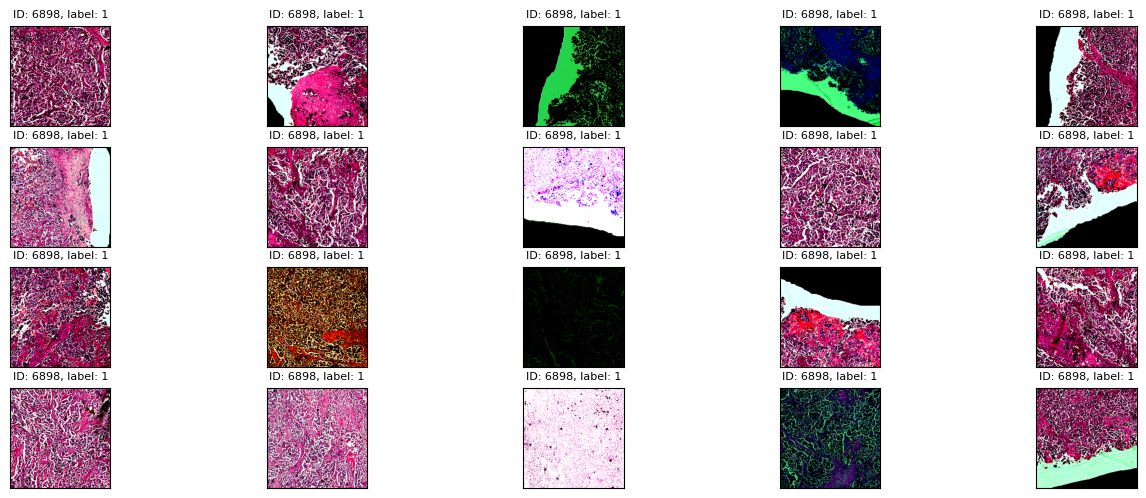

In [14]:
dls = get_dataloaders(train_df,  image_crops, config, split='train')
b = next(iter(dls))

k = 1
b_size = b['image'][k].size()[0]
row = 4
col = b_size // row

plt.figure(figsize=(16, 6))

for i in tqdm(range(b_size)):
    iid, image, target = b['image_id'][k], b['image'][k][i], b['target'][k]
    image = image.permute(1,2,0).cpu().numpy()
    
    plt.subplot(row, col, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.title(f"ID: {iid.cpu().numpy()}, label: {target.cpu().numpy()}", fontsize=8)
    plt.imshow(image);
    
gc.collect()

In [15]:
# """
# TMA + 25 WSI (Black background)
# (array([0.7595304 , 0.62903464, 0.73487246], dtype=float32),
#  array([0.16157271, 0.19009855, 0.15379326], dtype=float32))
 
# TMA + ALL WSI
# (array([0.77484655, 0.6602349 , 0.76623666], dtype=float32),
#  array([0.14762907, 0.15899615, 0.13695441], dtype=float32))
 
# TMA + 25 WSI (White background)
# (array([0.8014736, 0.674988 , 0.7787007], dtype=float32),

#  array([0.11983415, 0.16075522, 0.11095782], dtype=float32))
 
# TMA + ALL WSI
# (array([0.83333504, 0.7187119 , 0.8246802 ], dtype=float32),
#  array([0.08194634, 0.11530142, 0.0701494 ], dtype=float32))
# """

# Mean and standard deviation

### TMA Images

`(array([0.7723238 , 0.61636746, 0.72223914], dtype=float32), array([0.15487   , 0.20344967, 0.14965232], dtype=float32))`

### WSI Images

`(array([0.8393506 , 0.71817416, 0.83166176], dtype=float32), array([0.07376561, 0.10645077, 0.0612806 ], dtype=float32))`


### TMA and 125 WSI Images (black background)

`array([0.77799046, 0.65183514, 0.75950706], dtype=float32),
 array([0.14928007, 0.1674737 , 0.14027087], dtype=float32))`
 
### TMA and 125 WSI Images (white background)

`(array([0.82879466, 0.70345604, 0.81026554], dtype=float32),
 array([0.09126535, 0.13023499, 0.08277158], dtype=float32))`

In [16]:
# tma_index = train_df[train_df['is_tma']==True].index.tolist()
# wsi_index = train_df[train_df['is_tma']==False].index.tolist()

# tma_df = train_df.iloc[tma_index, :].reset_index(drop=True)
# tma_crops = [image_crops[i] for i in tma_index]

# wsi_df = train_df.iloc[wsi_index, :].sample(frac=1.0, random_state=2023).reset_index(drop=True)
# wsi_crops = [image_crops[i] for i in wsi_df.index.tolist()]

# df = pd.concat([wsi_df, tma_df], axis=0).reset_index(drop=True)
# all_crops = wsi_crops + tma_crops
# ts = transforms.Compose([
# #     transforms.Normalize(mean=(0.8172852, 0.71010786, 0.82839715), std=(0.10604138, 0.16353978, 0.11568955)),
#     transforms.ToTensor(),
# #     transforms.Normalize(mean=(0.8172852, 0.71010786, 0.82839715), std=(0.10604138, 0.16353978, 0.11568955)),
# ])

# ds = UBCTileDataset(df, all_crops, ts)

# dls = DataLoader(ds, shuffle=True, batch_size=32, num_workers=2, pin_memory=True)
# # wsi_df

In [17]:
# MEAN = list(); STD = list()
# for n, b in enumerate(dls):
#     mean = 0.
#     std = 0.
#     nb_samples = 0
#     for i in range(20):
#         data = b['image'][:, i, ...]
#         b_samples = data.size(0)
#         data = data.view(b_samples, data.size(1), -1)
#         mean += data.mean(2).sum(0)
#         std += data.std(2).sum(0) 
#         nb_samples += b_samples

#     mean /= nb_samples
#     std /= nb_samples
    
#     if n%10 == 1:
#         print(f"Mean: {mean}, std: {std}")
#     MEAN.append(mean.detach().cpu().numpy()); STD.append(std.detach().cpu().numpy())
    
# np.array(MEAN).mean(axis=0), np.array(STD).mean(axis=0)

# Attention pooling

In [18]:
class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(Attention, self).__init__(**kwargs)

        self.supports_masking = True

        self.bias = bias
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.features_dim = 0

        weight = torch.zeros(feature_dim, 1)
        nn.init.xavier_uniform_(weight)
        self.weight = nn.Parameter(weight)

        if bias:
            self.b = nn.Parameter(torch.zeros(step_dim))

    def forward(self, x, mask=None):
        feature_dim = self.feature_dim
        step_dim = x.shape[1] #self.step_dim

        eij = torch.mm(
            x.contiguous().view(-1, feature_dim),
            self.weight
        ).view(-1, step_dim)

        if self.bias:
            eij = eij + self.b

        eij = torch.tanh(eij)
        a = torch.exp(eij)

        if mask is not None:
            a = a * mask

        a = a / torch.sum(a, 1, keepdim=True) + 1e-10

        weighted_input = x * torch.unsqueeze(a, -1)
        return torch.sum(weighted_input, 1)

In [19]:
# timm.list_pretrained('resnetv2*')

### Good models

`tf_efficientnetv2_s.in21k_ft_in1k`

`tiny_vit_5m_224.dist_in22k_ft_in1k`, LB = `0.37` 

`tf_efficientnetv2_b3.in21k_ft_in1k`

`efficientnet_b3.ra2_in1k`

`resnet50.a1_in1k`

Credit to GM [theo viel](https://www.kaggle.com/code/theoviel/inference-mayo#Inference)

In [20]:
flush()

model_id_timm = 'timm/tiny_vit_5m_224.dist_in22k_ft_in1k' 
# model_id_timm = 'timm/tf_efficientnetv2_b3.in21k_ft_in1k'
    
class TileModel(nn.Module):
    """
    Model with an attention mechanism.
    """
    def __init__(self, model_name, num_classes=5, num_instances=20, average="ft", pretrained=True):
        super().__init__()

        self.encoder = timm.create_model(model_name, num_classes=num_classes, pretrained=pretrained)
        self.nb_ft = self.encoder.num_features
        self.num_classes = num_classes

        assert average in ["ft", "proba"], "Averaging not supported"
        self.average = average
#         self.norm = nn.LayerNorm(self.nb_ft)
#         self.attn = Attention(self.nb_ft, num_instances, bias=False)

        self.logits = nn.Linear(self.nb_ft, num_classes)

    def extract_features(self, x):
        fts = self.encoder.forward_features(x)

        if len(fts.size()) >= 4:  # cnn
            return fts.mean(-1).mean(-1)
        else:
            return fts.mean(-2)  # transfo

    def forward(self, x, w=None):
        n_tiles = x.size(1) if len(x.size()) > 4 else 1
        x = x.view(-1, *x.size()[-3:]).contiguous()  # bs x n_tiles x c x h x w -> bs*n_tiles x ...

        fts = self.extract_features(x)
        fts = fts.view(-1, n_tiles, self.nb_ft)  # bs*n_tiles x nb_ft -> bs x n_tiles x nb_ft
        
        # Attention pooling layer
#         fts = self.norm(fts)
#         fts = self.attn(fts)

        if self.average == "ft":
            if w is None:
                fts = fts.mean(1)  # avg pooling
            else:
                w = w.unsqueeze(-1)
                fts = (fts * w).sum(1) / w.sum(1)  # masked pooling

        logits = self.logits(fts)

        if self.average == "proba":
            if w is None:
                logits = logits.mean(1)  # avg pooling
            else:
                w = w.unsqueeze(-1)
                logits = (logits * w).sum(1) / w.sum(1)  # masked pooling

        return logits
    
    
    def freeze_encoder(self, flag):
        for param in self.encoder.parameters():
            param.requires_grad = not flag
            
            
# model = TileModel(model_name=model_id_timm, pretrained=False)
# model.freeze_encoder(True)
# model.eval()
# model(b['image']).softmax(dim=-1)

In [21]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        ft = self.alpha * (1 - pt) ** self.gamma
        focal_loss = ft * ce_loss
        
        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss

class MetricMonitor:
    def __init__(self, float_precision=4):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )


def ACC(y_true, y_preds):
    y_true = y_true.detach().cpu().numpy()
    y_preds = torch.argmax(y_preds, dim=1)
    y_preds = y_preds.detach().cpu().numpy()
    return metrics.balanced_accuracy_score(y_true, y_preds)

# def flush():
#     gc.collect()
#     torch.cuda.empty_cache()
#     torch.cuda.reset_peak_memory_stats()

In [22]:
def mixup(inputs, truth, clip=[0, 1]):
    indices = torch.randperm(inputs.size(0))
    shuffled_input = inputs[indices]
    shuffled_labels = truth[indices]
    
    lam = np.random.uniform(clip[0], clip[1])
    inputs = inputs * lam + shuffled_input * (1 - lam)
    return inputs, truth, shuffled_labels, lam


def train_with_mixup(model, optimizer, criterion, data_loader, scaler, device='cpu', epoch=1, n_iters=1000):
    model.train()
    train_loss = 0
    correct = 0
    n_total = 0
    example_ct = 0
    step_ct = 0
    metric_monitor = MetricMonitor()
    stream = tqdm(data_loader)
    for i, batch in enumerate(stream, start=1):
        xb, yb = batch['image'], batch['target']
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        
        do_mixup = False
        if random.random() < 0.5:
            do_mixup = True
            xb, yb, yb_mix, lam = mixup(xb, yb)
        
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(xb)
            outputs = outputs.softmax(dim=-1)
            loss = criterion(outputs, yb)
            if do_mixup:
                loss11 = criterion(outputs, yb_mix)
                loss = loss * lam + loss11 * (1 - lam)
            
        train_loss += loss.detach().float()
        scaler.scale(loss).backward()
        
        acc = ACC(yb, outputs)
        metric_monitor.update('Loss', loss.item())
        metric_monitor.update('Balanced Accuracy', acc)
        
        example_ct += len(xb)
        METRICS = {
            "train/train_loss": train_loss,
            "train/epoch": (i + 1 + (n_iters * epoch)) / n_iters,
            "train/example_ct": example_ct,
            "train/balanced_acc": acc,
        }
        
#         if (i + 1) < n_iters:
#             # log train metrics to wandb
#             wandb.log(METRICS)
            
        step_ct += 1
        
#         if (i+1) % n_iters == 0:
#             scaler.step(optimizer)
#             scaler.update()
#             optimizer.zero_grad(set_to_none=True)
            
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
            
        stream.set_description(
        "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor))
    
    train_loss_total = (train_loss / len(data_loader)).item()
    flush()
    
    return train_loss_total, METRICS


def train_one_loop(model, optimizer, criterion, data_loader, scaler, device='cpu', epoch=1, n_iters=1000):
    model.train()
    train_loss = 0
    correct = 0
    n_total = 0
    example_ct = 0
    step_ct = 0
    metric_monitor = MetricMonitor()
    stream = tqdm(data_loader)
    for i, batch in enumerate(stream, start=1):
        xb, yb = batch['image'], batch['target']
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(xb)
            outputs = outputs.softmax(-1)
            loss = criterion(outputs, yb)
            
        train_loss += loss.detach().float()
        scaler.scale(loss).backward()
        
        acc = ACC(yb, outputs)
        metric_monitor.update('Loss', loss.item())
        metric_monitor.update('Balanced Accuracy', acc)
        
        example_ct += len(xb)
        METRICS = {
            "train/train_loss": train_loss,
            "train/epoch": (i + 1 + (n_iters * epoch)) / n_iters,
            "train/example_ct": example_ct,
            "train/balanced_acc": acc,
        }
        
#         if (i + 1) < n_iters:
#             # log train metrics to wandb
#             wandb.log(METRICS)
            
        step_ct += 1
        
#         if (i+1) % n_iters == 0:
#             scaler.step(optimizer)
#             scaler.update()
#             optimizer.zero_grad(set_to_none=True)
            
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
            
        stream.set_description(
        "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor))
    
    train_loss_total = (train_loss / len(data_loader)).item()
    flush()
    
    return train_loss_total, METRICS
        
    
def valid_one_loop(model, criterion, data_loader, device='cpu', epoch=1):
    model.eval()
    valid_loss = 0
    correct = 0
    n_total = 0
    metric_monitor = MetricMonitor()
    stream = tqdm(data_loader)
    for i, batch in enumerate(stream, start=1):
        xb, yb = batch['image'], batch['target']
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            with torch.no_grad():
                outputs = model(xb)
                outputs = outputs.softmax(dim=-1)
#                 PREDS.append(torch.argmax(outputs, dim=1).detach().cpu().numpy())
            loss = criterion(outputs, yb)
            
        valid_loss += loss.detach().float()
        acc = ACC(yb, outputs)
        metric_monitor.update('Loss', loss.item())
        metric_monitor.update('Balanced Accuracy', acc)
        stream.set_description(
        "Epoch: {epoch}. Valid.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor))
        val_metrics = {
            "valid/val_loss": valid_loss,
            "valid/balanced_acc": acc,
        }
#         IDS.extend(iid.detach().cpu().numpy())
#         wandb.log(val_metrics)
    
    valid_loss_total = (valid_loss / len(data_loader)).item()
    flush()
    return valid_loss_total, val_metrics

In [23]:
name = model_id_timm.split('/')[-1]

def train(model, optimizer, criterion, train_loader, valid_loader, epochs, scheduler, lr_reduce, 
          scaler, device='cpu', device_ids=[0,1], fold=0, n_iters=100):
    
    model = nn.DataParallel(model, device_ids=device_ids)  
    model.to(device)
    best_metric = np.inf
    loss_min = np.inf
    es = 0
    for epoch in tqdm(range(1, epochs+1)):
        scheduler.step(epoch-1)
#         train_loss, train_metrics = train_one_loop(model, optimizer, criterion, train_loader, 
#                                     scaler=scaler, device=device, epoch=epoch, n_iters=n_iters)
        
        train_loss, train_metrics = train_with_mixup(model, optimizer, criterion, train_loader, 
                                    scaler=scaler, device=device, epoch=epoch, n_iters=n_iters)
        
        valid_loss, valid_metrics = valid_one_loop(model, criterion, valid_loader, device=device, epoch=epoch)
        
        train_metrics["train/rmse"] = train_loss
        valid_metrics["valid/rmse"] = valid_loss
#         wandb.log({**train_metrics, **valid_metrics})
        lr_reduce.step(valid_loss)
        metric = valid_loss
        if metric < best_metric:
            print(f"Best metric: ({best_metric:.6f} --> {metric:.6f}). Saving model ...")
            torch.save(model.module.state_dict(), f"{name}_fold_{fold}.pth")
            best_metric = metric
            es = 0
        else:
            es += 1
        
        if es > round(0.25*config['epochs']):
            print(f"Early stopping on epoch {epoch} for fold {fold} ...")
            break
            
            
def train_swa(model, optimizer, criterion, train_loader, valid_loader, epochs, scheduler, lr_reduce, 
          scaler, device='cpu', device_ids=[0, 1], fold=0, n_iters=100):
    
    model = nn.DataParallel(model, device_ids=device_ids)
    model.to(device)
    swa_model = torch.optim.swa_utils.AveragedModel(model)
    swa_optimizer = torch.optim.swa_utils.SWALR(optimizer, swa_lr=0.05)
    swa_start = 1
    best_metric = np.inf
    loss_min = np.inf
    for epoch in tqdm(range(1, epochs+1)):
        train_loss, train_metrics = train_one_loop(model, optimizer, criterion, train_loader, 
                                    scaler=scaler, device=device, epoch=epoch, n_iters=n_iters)
        valid_loss, valid_metrics, iids = valid_one_loop(model, criterion, valid_loader, device=device, epoch=epoch)
        if epoch > swa_start: 
            swa_model.update_parameters(model)
            swa_optimizer.step()
        else:
            scheduler.step(epoch-1)
            lr_reduce.step(valid_loss)
        
        metric = valid_loss
        if metric < best_metric:
            print(f"Best metric: ({best_metric:.6f} --> {metric:.6f}). Saving model ...")
            torch.save(model.state_dict(), f"{name}_fold_{fold}.pth")
            best_metric = metric
    batch = next(iter(valid_loader))
    torch.optim.swa_utils.update_bn(batch['image'], swa_model)

def predict(model, data_loader, loss_config, device='cpu'):
    model.to(device)
    model.eval()
    preds = np.empty((0, model.num_classes))
    
    for i, batch in enumerate(tqdm(data_loader, total=len(data_loader))):
        xb = batch['image']
        xb = xb.to(device, non_blocking=True)
        
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            with torch.inference_mode():
                outputs = model(xb)
                
                # get probabilities
                if loss_config['activation'] == 'sigmoid':
                    outputs = ouputs.sigmoid()
                elif loss_config['activation'] == 'softmax':
                    outputs = outputs.softmax(-1)
                preds = np.concatenate([preds, outputs.detach().cpu().numpy()])
                
    return preds

In [24]:
loss_config = dict()
loss_config['activation'] = 'softmax'

In [25]:
%%time
flush()

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} ...")

gc.collect()

kfold = model_selection.StratifiedKFold(n_splits=config['folds'], shuffle=True, random_state=config['seed'])
# kfold = model_selection.StratifiedGroupKFold(n_splits=config['folds'], shuffle=True, random_state=config['seed'])
# kfold = model_selection.KFold(n_splits=config['folds'], shuffle=True, random_state=config['seed'])

x = train_df.index
y = train_df['target'].values
g = train_df['is_tma'].values
OOF_PREDS = np.zeros(len(train_df))

for fold, (tr_idx, val_idx) in enumerate(kfold.split(x, y)):
#     run = wandb.init(
#         project="cgair-pytorch-baseline"
#     )
#     artifact = wandb.Artifact(f'fold_{fold}_weights', type='model')
    
    if fold > 1:
        break
    
#     if fold in [0,3,4]:
#         epochs = 10 if fold==3 else 12+fold
#     else:
#         epochs = config['epochs']
        
    print(f"\n===> Fold {fold} ...")
    
    train_ds = train_df.iloc[tr_idx]
    valid_ds = train_df.iloc[val_idx]
    train_ds = train_ds.reset_index(drop=True)
    valid_ds = valid_ds.reset_index(drop=True)
    
    train_image_crops = [image_crops[i] for i in tr_idx]
    valid_image_crops = [image_crops[i] for i in val_idx]
    
    train_loader = get_dataloaders(train_ds, train_image_crops, config, split='train')
    valid_loader = get_dataloaders(valid_ds, valid_image_crops, config, split='valid')
    
    model = TileModel(model_name=model_id_timm, average='ft', pretrained=True)
#     model.freeze_encoder(True)
    
#     optimizer = torch.optim.AdamW(model.parameters(), lr=config['learning_rate'])
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate']/config['warmup_factor'])
#     optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.9, weight_decay=1e-5)
    criterion = torch.nn.CrossEntropyLoss().to(device)
#     criterion = FocalLoss().to(device)
    scaler = torch.cuda.amp.GradScaler() 
#     scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    lr_reduce = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, config['epochs']-config['warmup_factor'])
#     scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, config['epochs'], eta_min=config['eta_min'])
    scheduler = GradualWarmupScheduler(optimizer, multiplier=config['warmup_factor'], total_epoch=config['warmup_factor'],
                                      after_scheduler=scheduler_cosine)
    num_training_steps = math.ceil(len(train_loader)/config['batch_size'])
#     wandb.config = config

    train(model, optimizer, criterion, train_loader, valid_loader, epochs=config['epochs'], scheduler=scheduler, 
        lr_reduce=lr_reduce, scaler=scaler, device=device, fold=fold, n_iters=num_training_steps)
    
#     train_swa(model, optimizer, criterion, train_loader, valid_loader, epochs=config['epochs'], scheduler=scheduler, 
#         lr_reduce=lr_reduce, scaler=scaler, device=device, fold=fold, n_iters=num_training_steps)
    fold_path = Path(f"../working/{name}_fold_{fold}.pth")
    WEIGHTS = torch.load(fold_path, map_location=torch.device('cpu'))
    inference_model = TileModel(model_name=model_id_timm, average='ft', pretrained=False)
    inference_model.load_state_dict(WEIGHTS)
    PREDS = predict(inference_model, valid_loader, loss_config, device=device)
    print(f"\nFold {fold} performance: {metrics.balanced_accuracy_score(valid_ds['target'].values, np.argmax(PREDS, axis=1)):.4f}\n")
    OOF_PREDS[val_idx] = np.argmax(PREDS, axis=1)

    del model, inference_model, train_loader, valid_loader, train_ds, valid_ds
#     artifact.add_file(f"{name}_fold_{fold}.pth")
#     run.log_artifact(artifact)
# wandb.finish()
    flush()
    
print(f"\nOOF performance: {metrics.balanced_accuracy_score(train_df['target'].values, OOF_PREDS):.4f}\n")

Using cuda:0 ...

===> Fold 0 ...


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Best metric: (inf --> 1.602922). Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Best metric: (1.602922 --> 1.560185). Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Best metric: (1.560185 --> 1.332936). Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Best metric: (1.332936 --> 1.303433). Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Best metric: (1.303433 --> 1.272410). Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Best metric: (1.272410 --> 1.261639). Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 00013: reducing learning rate of group 0 to 2.9815e-05.


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Best metric: (1.261639 --> 1.234052). Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Best metric: (1.234052 --> 1.225970). Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Best metric: (1.225970 --> 1.210214). Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 00033: reducing learning rate of group 0 to 1.2653e-05.


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 00039: reducing learning rate of group 0 to 6.1832e-06.


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Early stopping on epoch 40 for fold 0 ...


  0%|          | 0/14 [00:00<?, ?it/s]


Fold 0 performance: 0.6553


===> Fold 1 ...


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Best metric: (inf --> 1.591140). Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Best metric: (1.591140 --> 1.561972). Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Best metric: (1.561972 --> 1.379693). Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Best metric: (1.379693 --> 1.323466). Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Best metric: (1.323466 --> 1.298691). Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Best metric: (1.298691 --> 1.234323). Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Best metric: (1.234323 --> 1.229347). Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 00015: reducing learning rate of group 0 to 2.9266e-05.


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Best metric: (1.229347 --> 1.216805). Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Best metric: (1.216805 --> 1.175784). Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 00032: reducing learning rate of group 0 to 1.3823e-05.


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Best metric: (1.175784 --> 1.175605). Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Best metric: (1.175605 --> 1.171081). Saving model ...


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 00042: reducing learning rate of group 0 to 3.5939e-06.


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 00048: reducing learning rate of group 0 to 4.1445e-07.


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Early stopping on epoch 49 for fold 1 ...


  0%|          | 0/14 [00:00<?, ?it/s]


Fold 1 performance: 0.7122


OOF performance: 0.3902

CPU times: user 33min 12s, sys: 6min 37s, total: 39min 49s
Wall time: 1h 4min 38s


In [26]:
#     OOF_PREDS[val_idx] = np.argmax(PREDS, axis=1)

In [27]:
# tile_counts = []
# for i in tqdm(range(len(image_crops))):
#     tile_counts.append(len(image_crops[i]))
    
# image_ids = train_df.loc[:, 'image_id'].tolist()
# labels = train_df.loc[:, 'target'].tolist()

# # image_ids = [40, 41, 42, 43]; labels = [0, 1, 0, 1]; tile_counts = [20, 15, 18, 22]
# [[image_id, label] for image_id, label, count in zip(image_ids, labels, tile_counts) for _ in range(count)]

In [28]:
# np.unique(tile_counts, return_counts=True)

In [29]:
# metrics.balanced_accuracy_score(train_df['target'].values, OOF_PREDS)
# next(iter(valid_loader))

# Model

In [30]:
# def define_model(
#     name,
#     num_classes=5,
#     pretrained_weights="",
#     pretrained=True,
#     average="ft"
# ):
#     """
#     Loads a pretrained model & builds the architecture.
#     Supports timm models.

#     Args:
#         name (str): Model name
#         num_classes (int, optional): Number of classes. Defaults to 1.
#         pretrained_weights (str, optional): Path to pretrained encoder weights. Defaults to ''.
#         pretrained (bool, optional): Whether to load timm pretrained weights.

#     Returns:
#         torch model -- Pretrained model.
#     """
#     # Load pretrained model
#     encoder = getattr(timm.models, name)(pretrained=pretrained)
#     encoder.name = name

#     # Tile Model
#     model = TileModel(
#         encoder,
#         num_classes=num_classes,
#         average=average,
#     )

#     if pretrained_weights:
#         # raise NotImplementedError
#         model = load_model_weights(model, pretrained_weights, verbose=1, strict=False)

#     return model